In [20]:
import os
import cv2
import torch
import tonic
import time
import random
import math
import numpy as np
import albumentations as A

from natsort import natsorted
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset
from tonic import slicers, transforms, functional
from EvEye.utils.tonic.functional.ToFrameStack import to_frame_stack_numpy
from EvEye.utils.tonic.slicers.SliceEventsAtIndices import slice_events_at_timepoints
from EvEye.utils.cache.MemmapCacheStructedEvents import (
    load_cached_structed_events,
    load_cached_structed_ellipses,
    load_memmap,
)
from EvEye.utils.visualization.visualization import visualize, save_image, draw_ellipse
from EvEye.utils.processor.TxtProcessor import TxtProcessor
from EvEye.utils.processor.HDF5Processor import HDF5Processor
from EvEye.utils.tonic.functional.CutMaxCount import cut_max_count

In [21]:
class DavisEyeEllipseDataset(Dataset):
    def __init__(
        self,
        root_path: Path | str,
        split="train",  # 'train', 'val' or 'test'
        time_window=10000,  # us
        sensor_size=(346, 260, 2),
        events_interpolation="causal_linear",
    ):
        self.root_path = Path(root_path)
        self.data_path = self.root_path / "cached_data"
        self.ellipse_path = self.root_path / "cached_ellipse"
        self.split = split
        self.time_window = time_window
        self.sensor_size = sensor_size
        self.events_interpolation = events_interpolation
        self.num_frames_list, self.total_frames = self.get_nums()
        self.total_train_frames = math.floor(self.total_frames * 0.7)
        self.total_val_frames = self.total_frames - self.total_train_frames

    def load_events(self, file_id):
        batch_id = file_id // 50
        event_id = file_id % 50
        events_batch_path = self.data_path / f"events_batch_{batch_id}.memmap"
        events_info_path = self.data_path / f"events_batch_info_{batch_id}.txt"
        event_indices_path = self.data_path / f"events_indices_{batch_id}.npy"
        events = load_memmap(events_batch_path, events_info_path)
        start_index, end_index = np.load(event_indices_path)[event_id]
        event = events[start_index:end_index]

        return event

    def get_nums(self):
        num_frames_list = []

        ellipses_list = load_cached_structed_ellipses(self.ellipse_path)
        for ellipses in ellipses_list:
            num_frames_list.append(len(ellipses))

        return num_frames_list, sum(num_frames_list)

    def get_index(self, file_lens, index):
        file_lens_cumsum = np.cumsum(np.array(file_lens))
        file_id = np.searchsorted(file_lens_cumsum, index, side="right")
        sample_id = index - file_lens_cumsum[file_id - 1] if file_id > 0 else index

        return file_id, sample_id

    def convert_to_ellipse(self, label):
        center = (float(label[1]), float(label[2]))
        axes = (float(label[3]), float(label[4]))
        angle = float(label[5])
        ellipse = (center, axes, angle)

        return ellipse

    def __len__(self):
        if self.split == "train":
            return self.total_train_frames
        elif self.split == "val":
            return self.total_val_frames

    def __getitem__(self, index):
        if self.split == "train":
            index = index
        elif self.split == "val":
            index = index + self.total_train_frames

        file_id, sample_id = self.get_index(self.num_frames_list, index)

        self.events = self.load_events(file_id)
        self.ellipses = load_cached_structed_ellipses(self.ellipse_path)

        ellipse = self.ellipses[file_id][sample_id]
        end_event_time = ellipse['t']
        start_event_time = end_event_time - self.time_window
        event_segment = slice_events_at_timepoints(
            self.events, start_event_time, end_event_time
        )
        event_frame = to_frame_stack_numpy(
            event_segment,
            self.sensor_size,
            1,
            self.events_interpolation,
            start_event_time,
            end_event_time,
        ).squeeze(0)
        event_frame_vis = visualize(event_frame)

        return event_frame_vis, ellipse

In [22]:
dataset = DavisEyeEllipseDataset(
    root_path="/mnt/data2T/junyuan/eye-tracking/datasets/MemmapDavisEyeEllipseDataset",
    split="train",
    time_window=10000,
    sensor_size=(346, 260, 2),
    events_interpolation="causal_linear",
)

(260, 346, 3)
114207


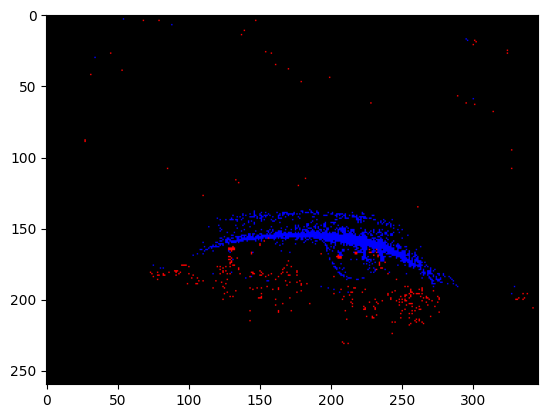

In [23]:
import matplotlib.pyplot as plt

print(dataset[15][0].shape)
print(len(dataset))
plt.imshow(dataset[15][0])

(1657710794177484, 215.49, 170.86, 39.68, 27.91, 30.87)


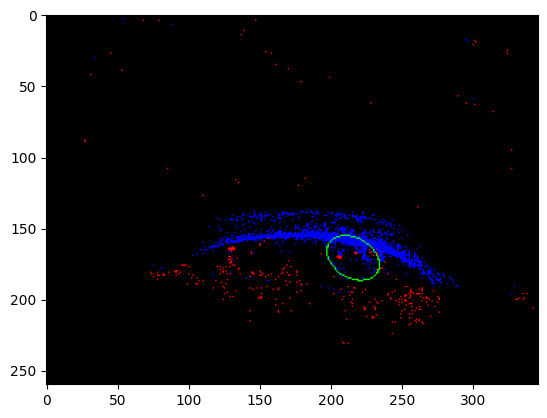

In [24]:
print(dataset[15][1])
ellipse_to_draw = dataset.convert_to_ellipse(dataset[15][1])
canvas = dataset[15][0]
cv2.ellipse(canvas, ellipse_to_draw, (0, 255, 0), 1)
plt.imshow(canvas)

In [25]:
import json
from pathlib import Path
from tqdm import tqdm
import numpy as np
import os


def convert_to_coco_format(
    dataset, output_image_folder, output_json_path, category_id=1
):
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [{"id": category_id, "name": "eye", "supercategory": "none"}],
    }

    annotation_id = 1
    os.makedirs(output_image_folder, exist_ok=True)

    for index in tqdm(range(10000, 12000)):
        event_frame_vis, ellipse = dataset[index]

        # Save the image
        image_path = Path(output_image_folder) / f"{index:05d}.png"
        # save_image(event_frame_vis, str(image_path))

        # Add image info to COCO format
        height, width = event_frame_vis.shape[:2]
        image_info = {
            "license": 1,
            "file_name": image_path.name,
            "height": height,
            "width": width,
            "id": index + 1 - 10000,
        }
        coco_format["images"].append(image_info)

        # Add annotation info to COCO format
        timestamp, x_center, y_center, a, b, angle = ellipse
        annotation_info = {
            "iscrowd": 0,
            "image_id": index + 1,
            "bbox": [x_center, y_center, a, b, angle],
            "category_id": category_id,
            "id": annotation_id,
        }
        coco_format["annotations"].append(annotation_info)
        annotation_id += 1

    # Save to JSON file
    with open(output_json_path, 'w') as f:
        json.dump(coco_format, f, indent=4)


# 使用示例
dataset = DavisEyeEllipseDataset(
    root_path="/mnt/data2T/junyuan/eye-tracking/datasets/MemmapDavisEyeEllipseDataset",
    split="train",
    time_window=10000,
    sensor_size=(346, 260, 2),
    events_interpolation="causal_linear",
)
output_image_folder = '/mnt/data2T/junyuan/el-net/frames'
output_train_path = '/mnt/data2T/junyuan/el-net/train.json'
output_val_path = '/mnt/data2T/junyuan/el-net/val.json'

# convert_to_coco_format(dataset, output_image_folder, output_train_path)

In [26]:
convert_to_coco_format(dataset, output_image_folder, output_val_path)

100%|██████████| 2000/2000 [00:08<00:00, 222.37it/s]
